In [1]:
# Experiment no.17 pilot

In [2]:
# Constants
exp_no = 'exp17'
path_root = '/home/hwkang/jupyter/root/'
path_dataset = path_root + 'dataset/'
path_result = path_root + 'result/'
path_result_root = path_result + exp_no + '/'
path_result_image = path_result_root + 'image/'
path_result_model = path_result_root + 'model/'
path_result_loss = path_result_root + 'loss/'
path_result_accuracy = path_result_root + 'accuracy/'
path_result_meta = path_result_root + 'meta/'
path_utility = path_root + 'utility/'

In [3]:
# Imports
import sys
sys.path.append(path_root)
sys.path.append(path_dataset)
sys.path.append(path_result)

In [4]:
# PyTorch family
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
# Utilities
import argparse
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

from utility.common import *
from utility.preprocess import *
from utility.synthesize import *
from utility.visualize import *
from model.SimpleCNN import *

In [6]:
# Data preprocessing
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root=path_dataset, train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root=path_dataset, train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
dataset_ratio = 0.1 # Controllable parameter
train_dataset = get_subset(train_dataset, dataset_ratio)
test_dataset = get_subset(test_dataset, dataset_ratio)

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [9]:
multi_noised_train_dataset = MultiNoisedDataset(train_loader)
multi_noised_test_dataset = MultiNoisedDataset(test_loader)

multi_noised_train_loader = DataLoader(dataset=multi_noised_train_dataset, batch_size=64, shuffle=True)
multi_noised_test_loader = DataLoader(dataset=multi_noised_test_dataset, batch_size=64, shuffle=False)

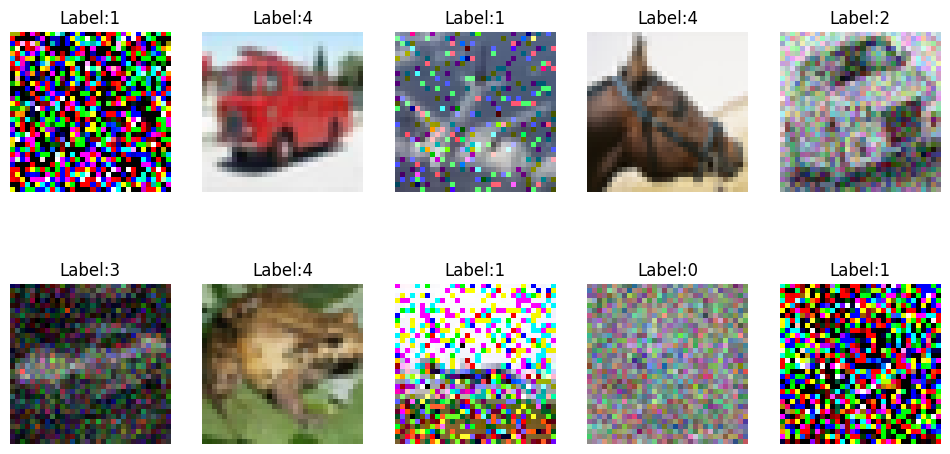

In [10]:
visualize_noisy_sample(pilot=True, loader=multi_noised_test_loader)

In [11]:
# Setup hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MNC_CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
epoch_rec = []

In [12]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in multi_noised_train_loader:
        # 이진 분류를 위해 라벨을 0 또는 1로 변경 (임시로)
        #labels = labels.float().unsqueeze(1)

        inputs, labels = inputs.to(device), labels.to(device)
        
        # 옵티마이저 초기화
        optimizer.zero_grad()
        
        # 순전파
        outputs = model(inputs)
        
        # 손실 계산
        loss = criterion(outputs, labels)
        
        # 역전파
        loss.backward()
        
        # 옵티마이저 업데이트
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(multi_noised_train_loader.dataset)
    epoch_rec.append(epoch_loss)
        
    if( epoch % 10 == 9 ):
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

/home/hwkang/jupyter/venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 10/50, Loss: 0.3133
Epoch 20/50, Loss: 0.2275
Epoch 30/50, Loss: 0.1703
Epoch 40/50, Loss: 0.1675
Epoch 50/50, Loss: 0.1282


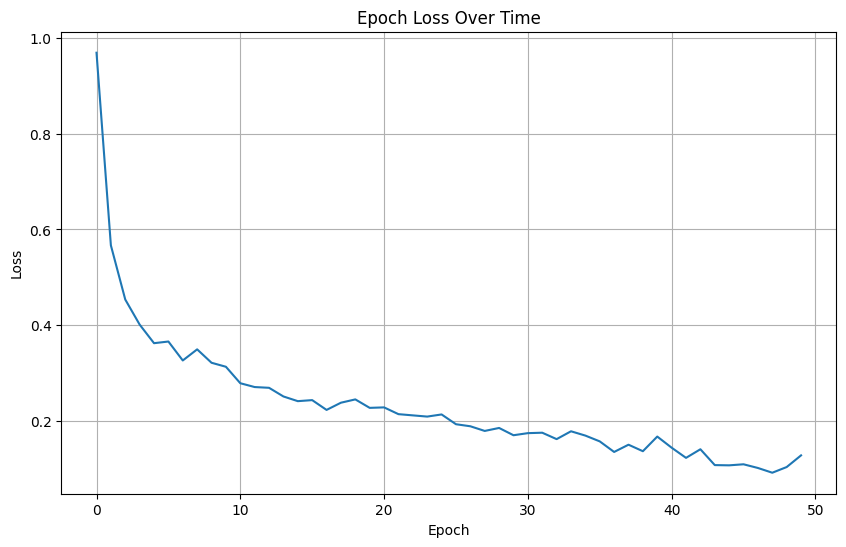

In [13]:
visualize_epoch_loss(pilot=True, epoch_loss=epoch_rec)

In [14]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in multi_noised_test_loader:
        #labels = labels.float().unsqueeze(1)  # 이진 분류를 위해 라벨을 0 또는 1로 변경 (임시로)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted_value, predicted_class = torch.max(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_class.cpu().numpy())
        total += labels.size(0)
        correct += (predicted_class == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 93.10%


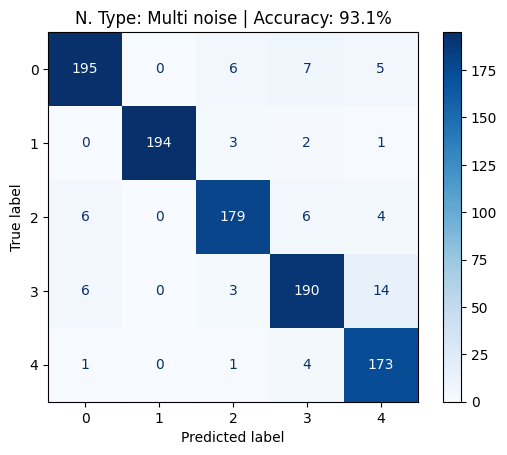

In [15]:
visualize_confusion_matrix(pilot=True, all_labels=all_labels, all_predictions=all_predictions, num_label=5, noise_type='Multi noise', accuracy=accuracy)

In [16]:
prs, res, f1s = calculate_confusion_metrics(all_labels, all_predictions, num_class=5)

In [18]:
for idx, pr, re, f1 in zip(list(range(5)), prs, res, f1s):
    print(f'Class [{idx}] | Pr.: {pr:.6f} | Re.: {re:.6f} | F1.: {f1:.6f}')

Class [0] | Pr.: 0.937500 | Re.: 0.915493 | F1.: 0.926366
Class [1] | Pr.: 1.000000 | Re.: 0.970000 | F1.: 0.984772
Class [2] | Pr.: 0.932292 | Re.: 0.917949 | F1.: 0.925065
Class [3] | Pr.: 0.909091 | Re.: 0.892019 | F1.: 0.900474
Class [4] | Pr.: 0.878173 | Re.: 0.966480 | F1.: 0.920213
